### Data Cleaning Notebook: For a dataset with zipcode as rows, we did dummied the ratings and Price.
### For the categories I used countvectorizer to assign the matrix to the original data set.
### As the Countvecrizer does not perform well, I saved the data with two copies, one with countvecrizer one without

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import BaggingRegressor, RandomForestRegressor, AdaBoostRegressor
from sklearn.svm import SVR
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error

from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import Lasso
from sklearn.linear_model import LassoCV

from sklearn.preprocessing import FunctionTransformer
from sklearn.pipeline import FeatureUnion
from sklearn.cluster import KMeans

import pickle

In [2]:
df= pd.read_csv('../data/03_data_income.csv')
df.head()

,id,latitude,longitude,price,review_count,rating,zip_code,city,alias,category,med_agi,avg_agi,count
0,zzvkb4J_sQAk8N20OWdZhg,33.911154,-117.881259,2,1257.0,3.5,92821,Brea,lucilles-smokehouse-bar-b-que-brea,"['bbq', 'smokehouse', 'southern']",86070,106163,170
1,zWs68lBY2PyNOTRJhxXapg,33.911959,-117.867374,1,22.0,3.0,92821,Brea,subway-restaurants-brea-4,['sandwiches'],86070,106163,170
2,zOYNwoDjpg6Ehwn0RKX9qA,33.911283,-117.867449,2,367.0,3.5,92821,Brea,nekter-juice-bar-brea,"['juicebars', 'acaibowls', 'icecream']",86070,106163,170
3,zNNLl821AlzApHYqRxNALw,33.911431,-117.865941,1,84.0,2.5,92821,Brea,arbys-brea-2,"['sandwiches', 'hotdogs']",86070,106163,170
4,zJ4pvxtpo3Y5LvylLXmCzA,33.932860,-117.916253,2,231.0,4.0,92821,Brea,portofino-trattoria-brea,['italian'],86070,106163,170


In [3]:
df.shape

(28112, 13)

In [4]:
df.drop(columns = ['id','med_agi'], inplace = True)

## change the data set from restaurant based to zipcode based

In [5]:
df_pivot = df.pivot_table(index = ['zip_code'])
df_pivot.head()

,avg_agi,count,latitude,longitude,price,rating,review_count
zip_code,,,,,,,
90001,45650,92,33.976491,-118.248684,1.282609,3.619565,49.956522
90002,44463,21,33.954422,-118.245431,1.095238,3.380952,27.904762
90003,43342,71,33.972703,-118.271297,1.197183,3.281690,35.915493
90004,82091,155,34.075176,-118.305680,1.529032,3.835484,240.883871
90005,49310,147,34.059249,-118.300776,1.639456,3.717687,358.448980


##  Create New column for the combo of Price*review_count

In [6]:
df_pivot['price*rating'] = df_pivot['price'] * df_pivot['rating']

In [7]:
df_pivot['price*review_count']=df_pivot['price']*df_pivot['review_count']

In [8]:
df_pivot.head()

,avg_agi,count,latitude,longitude,price,rating,review_count,price*rating,price*review_count
zip_code,,,,,,,,,
90001,45650,92,33.976491,-118.248684,1.282609,3.619565,49.956522,4.642486,64.074669
90002,44463,21,33.954422,-118.245431,1.095238,3.380952,27.904762,3.702948,30.562358
90003,43342,71,33.972703,-118.271297,1.197183,3.281690,35.915493,3.928784,42.997421
90004,82091,155,34.075176,-118.305680,1.529032,3.835484,240.883871,5.864579,368.319209
90005,49310,147,34.059249,-118.300776,1.639456,3.717687,358.448980,6.094984,587.661252


## Breakdown the price from original Pivot table(average) to count how many we have for each price category

In [9]:
count_price = (pd.crosstab(df["zip_code"], df['price']))
count_price.columns = ['price_1','price_2','price_3','price_4']
count_price.head()

,price_1,price_2,price_3,price_4
zip_code,,,,
90001,66,26,0,0
90002,19,2,0,0
90003,60,9,1,1
90004,77,74,4,0
90005,56,88,3,0


# Break Down for Rating column

In [10]:
count_rating = (pd.crosstab(df["zip_code"], df['rating']))
count_rating.columns = ['rating_0.0','rating_1.0','rating_1.5','rating_2.0','rating_2.5','rating_3.0','rating_3.5','rating_4.0','rating_4.5','rating_5']
count_rating.head()

,rating_0.0,rating_1.0,rating_1.5,rating_2.0,rating_2.5,rating_3.0,rating_3.5,rating_4.0,rating_4.5,rating_5
zip_code,,,,,,,,,,
90001,0,0,4,8,9,9,14,19,17,12
90002,0,0,3,4,1,0,1,6,3,3
90003,0,2,7,10,7,7,8,11,10,9
90004,0,0,1,2,12,15,27,57,27,14
90005,0,1,2,5,5,19,26,58,30,1


## combine price and rating to zipcode file

In [11]:
df_count = pd.merge(count_price, count_rating, left_on = 'zip_code', right_on = 'zip_code')
df_count.head()

,price_1,price_2,price_3,price_4,rating_0.0,rating_1.0,rating_1.5,rating_2.0,rating_2.5,rating_3.0,rating_3.5,rating_4.0,rating_4.5,rating_5
zip_code,,,,,,,,,,,,,,
90001,66,26,0,0,0,0,4,8,9,9,14,19,17,12
90002,19,2,0,0,0,0,3,4,1,0,1,6,3,3
90003,60,9,1,1,0,2,7,10,7,7,8,11,10,9
90004,77,74,4,0,0,0,1,2,12,15,27,57,27,14
90005,56,88,3,0,0,1,2,5,5,19,26,58,30,1


In [12]:
df_count.shape

(327, 14)

In [13]:
df_pivot.shape

(327, 9)

## Below is the combined data for zipcode, price, and rating, without countvecrizer the catogory

In [14]:
df_dummy = pd.merge(df_pivot, df_count, on="zip_code")
df_dummy.drop(columns = ['price','rating'] ,inplace = True)
df_dummy.reset_index(inplace = True)
df_dummy.head()

,zip_code,avg_agi,count,latitude,longitude,review_count,price*rating,price*review_count,price_1,price_2,...,rating_0.0,rating_1.0,rating_1.5,rating_2.0,rating_2.5,rating_3.0,rating_3.5,rating_4.0,rating_4.5,rating_5
0,90001,45650,92,33.976491,-118.248684,49.956522,4.642486,64.074669,66,26,...,0,0,4,8,9,9,14,19,17,12
1,90002,44463,21,33.954422,-118.245431,27.904762,3.702948,30.562358,19,2,...,0,0,3,4,1,0,1,6,3,3
2,90003,43342,71,33.972703,-118.271297,35.915493,3.928784,42.997421,60,9,...,0,2,7,10,7,7,8,11,10,9
3,90004,82091,155,34.075176,-118.305680,240.883871,5.864579,368.319209,77,74,...,0,0,1,2,12,15,27,57,27,14
4,90005,49310,147,34.059249,-118.300776,358.448980,6.094984,587.661252,56,88,...,0,1,2,5,5,19,26,58,30,1


In [15]:
df_dummy['zip_code'] = df_dummy['zip_code'].astype(str)

In [16]:
df_dummy.dtypes

zip_code               object
avg_agi                 int64
count                   int64
latitude              float64
longitude             float64
review_count          float64
price*rating          float64
price*review_count    float64
price_1                 int64
price_2                 int64
price_3                 int64
price_4                 int64
rating_0.0              int64
rating_1.0              int64
rating_1.5              int64
rating_2.0              int64
rating_2.5              int64
rating_3.0              int64
rating_3.5              int64
rating_4.0              int64
rating_4.5              int64
rating_5                int64
dtype: object

# Making the category a matrix via countvectrizor 

In [17]:
cate_dict = df['category'].to_dict()

In [18]:
for i in cate_dict:
    cate_dict[i] = cate_dict[i].replace('[', '')
    cate_dict[i] = cate_dict[i].replace(']', '')
    cate_dict[i] = cate_dict[i].replace('\'', '')
    cate_dict[i] = cate_dict[i].split(', ')

In [19]:
df_cate= pd.DataFrame.from_dict(cate_dict, orient = 'index')
df_cate.head()

,0,1,2,3,4
0,bbq,smokehouse,southern,None,None
1,sandwiches,None,None,None,None
2,juicebars,acaibowls,icecream,None,None
3,sandwiches,hotdogs,None,None,None
4,italian,None,None,None,None


In [20]:
df_cate['zip_code'] = df['zip_code']
df_cate

,0,1,2,3,4,zip_code
0,bbq,smokehouse,southern,None,None,92821
1,sandwiches,None,None,None,None,92821
2,juicebars,acaibowls,icecream,None,None,92821
3,sandwiches,hotdogs,None,None,None,92821
4,italian,None,None,None,None,92821
...,...,...,...,...,...,...
28107,foodtrucks,sandwiches,salad,None,None,92841
28108,foodtrucks,tacos,None,None,None,92841
28109,cheesesteaks,sandwiches,chicken_wings,None,None,92845
28110,mexican,None,None,None,None,91764


In [21]:
categories_df = df_cate.astype(str).groupby('zip_code').agg(lambda x: ' '.join(x.unique())) ##borrowwed from Erin Hwang 

In [22]:
categories_df['cate_text_by_zip'] = categories_df[0] + ' ' + categories_df[1] + ' ' + categories_df[2] + ' ' + categories_df[3] + ' ' + categories_df[4]
categories_df.head()##borrowwed from Erin Hwang

,0,1,2,3,4,cate_text_by_zip
zip_code,,,,,,
90001,mexican foodtrucks burgers newamerican seafood...,None comfortfood sandwiches breakfast_brunch s...,None sandwiches catering bbq herbsandspices ch...,None,None,mexican foodtrucks burgers newamerican seafood...
90002,mexican pizza chicken_wings chinese sandwiches...,foodstands hotdogs None breakfast_brunch juice...,None desserts coffee foodstands chicken_wings ...,None,None,mexican pizza chicken_wings chinese sandwiches...
90003,breakfast_brunch grocery streetvendors mexican...,burgers bakeries mexican None breakfast_brunch...,mexican meats None burgers sandwiches coffee g...,None,None,breakfast_brunch grocery streetvendors mexican...
90004,coffee bbq filipino pizza korean gastropubs ba...,breakfast_brunch foodstands None kosher bbq ko...,cafes None salad german latin breakfast_brunch...,None,None,coffee bbq filipino pizza korean gastropubs ba...
90005,salvadoran bakeries bars bubbletea korean taco...,None korean shavedice bbq breakfast_brunch bub...,None asianfusion icecream tradamerican dessert...,None,None,salvadoran bakeries bars bubbletea korean taco...


In [23]:
cvec = CountVectorizer()

In [24]:
categories_df.reset_index(inplace = True)

In [25]:
X = categories_df['cate_text_by_zip']
y = categories_df['zip_code']

In [26]:
df_cate = pd.DataFrame(cvec.fit_transform(X).toarray(),
                columns=cvec.get_feature_names() ) #
df_cate.head()

,acaibowls,accessories,acupuncture,afghani,african,airportlounges,amusementparks,antiques,appliances,arabian,...,whiskeybars,wholesale_stores,wholesalers,wine_bars,wineries,winetasteclasses,winetastingroom,womenscloth,wraps,yoga
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## save the data with countvecrizer. As we tried model with countevecrizer on how frequent each category shows in each zip code and it did not perform well, our model uses the one without vecrerizer.

In [27]:
df = pd.concat([df_dummy, df_cate], axis=1, sort=False)
df.head()

,zip_code,avg_agi,count,latitude,longitude,review_count,price*rating,price*review_count,price_1,price_2,...,whiskeybars,wholesale_stores,wholesalers,wine_bars,wineries,winetasteclasses,winetastingroom,womenscloth,wraps,yoga
0,90001,45650,92,33.976491,-118.248684,49.956522,4.642486,64.074669,66,26,...,0,0,0,0,0,0,0,0,0,0
1,90002,44463,21,33.954422,-118.245431,27.904762,3.702948,30.562358,19,2,...,0,0,0,0,0,0,0,0,0,0
2,90003,43342,71,33.972703,-118.271297,35.915493,3.928784,42.997421,60,9,...,0,0,0,0,0,0,0,0,0,0
3,90004,82091,155,34.075176,-118.305680,240.883871,5.864579,368.319209,77,74,...,0,0,0,0,0,0,0,0,0,0
4,90005,49310,147,34.059249,-118.300776,358.448980,6.094984,587.661252,56,88,...,0,0,0,0,0,0,0,0,0,0


In [28]:
# df.to_csv('../data/data_cv.csv')

## Begin to Model

In [29]:
X = df_dummy.drop(columns=['avg_agi','latitude','longitude','zip_code'])
features = list(X.columns)
y = df_dummy['avg_agi']

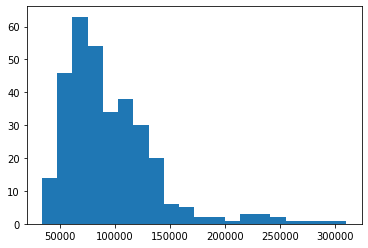

In [30]:
plt.hist(df["avg_agi"], bins=20);

In [31]:
y = np.log(df_dummy["avg_agi"])  #y = np.log(df.copy()["ave_agi"])

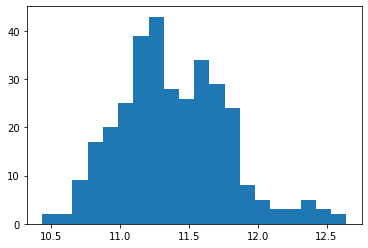

In [32]:
plt.hist(y, bins=20);

In [33]:
X_train, X_test, y_train, y_test = train_test_split(
    X.copy(), y.copy(), random_state=42, test_size=0.3
)

# Trying different models
 - linear regression
 - knn regression
 - decision tree
 - bagging
 - random_forest
 - ada boost
 - support_vector

In [34]:
linear_reg = LinearRegression()
linear_reg.fit(X_train, y_train)

knn_reg = KNeighborsRegressor()
knn_reg.fit(X_train, y_train)

cart_reg = DecisionTreeRegressor()
cart_reg.fit(X_train, y_train)

bagged_reg = BaggingRegressor()
bagged_reg.fit(X_train, y_train)

random_forest_reg = RandomForestRegressor()
random_forest_reg.fit(X_train, y_train)

adaboost_reg = AdaBoostRegressor()
adaboost_reg.fit(X_train, y_train)

support_vector_reg = SVR()
support_vector_reg.fit(X_train, y_train)

xgb = XGBRegressor()
xgb.fit(X_train, y_train)

[08:48:33] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\m6zha\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\m6zha\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\m6zha\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
             n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=None, subsample=1, verbosity=1)

# Evaluate our models

In [35]:
def rmse_score(model, X_train, X_test, y_train, y_test):
    mse_train = mean_squared_error(y_true = y_train,
                                  y_pred = model.predict(X_train))
    mse_test = mean_squared_error(y_true = y_test,
                                  y_pred = model.predict(X_test))
    rmse_train = mse_train ** 0.5
    rmse_test = mse_test ** 0.5
    
    print("The training RMSE for " + str(model) + " is: " + str(rmse_train))
    print("The testing RMSE for " + str(model) + " is: " + str(rmse_test))
    return (rmse_train, rmse_test)

## Evaluate linear regression

In [36]:
rmse_score(linear_reg, X_train, X_test, y_train, y_test)

The training RMSE for LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False) is: 0.2969672872776437
The testing RMSE for LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False) is: 0.2662207450805649


(0.2969672872776437, 0.2662207450805649)

In [37]:
print(linear_reg.score(X_train, y_train))
print (linear_reg.score(X_test, y_test))

0.4491534354262235
0.5025883735737728


In [38]:
linear_reg.coef_

array([-6.19805529e-03,  1.07916282e-03,  1.08792168e-01, -4.28880354e-04,
       -6.29593353e-03,  2.99962150e-05,  4.88534017e-03, -4.81745816e-03,
       -4.25007252e-17, -4.36152433e-02, -2.96179560e-02,  9.25808196e-03,
        2.45946545e-02,  1.36724558e-02,  1.20913917e-02,  4.03073143e-03,
        4.74583633e-03, -1.35800771e-03])

## Evaluate Knn

In [39]:
rmse_score(knn_reg, X_train, X_test, y_train, y_test)

The training RMSE for KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
                    metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                    weights='uniform') is: 0.259561676122915
The testing RMSE for KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
                    metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                    weights='uniform') is: 0.31851443602678914


(0.259561676122915, 0.31851443602678914)

In [40]:
print(knn_reg.score(X_train, y_train))
print (knn_reg.score(X_test, y_test))

0.5791817543284793
0.2879829648876202


## Evaluate decision tree

In [41]:
rmse_score(cart_reg, X_train, X_test, y_train, y_test)

The training RMSE for DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
                      max_leaf_nodes=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      presort=False, random_state=None, splitter='best') is: 0.0
The testing RMSE for DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
                      max_leaf_nodes=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      presort=False, random_state=None, splitter='best') is: 0.35885969200518075


(0.0, 0.35885969200518075)

In [42]:
print(cart_reg.score(X_train, y_train))
print (cart_reg.score(X_test, y_test))

1.0
0.09618092432361723


## Evaluate Bagging model

In [43]:
rmse_score(bagged_reg, X_train, X_test, y_train, y_test)

The training RMSE for BaggingRegressor(base_estimator=None, bootstrap=True, bootstrap_features=False,
                 max_features=1.0, max_samples=1.0, n_estimators=10,
                 n_jobs=None, oob_score=False, random_state=None, verbose=0,
                 warm_start=False) is: 0.12835992989491413
The testing RMSE for BaggingRegressor(base_estimator=None, bootstrap=True, bootstrap_features=False,
                 max_features=1.0, max_samples=1.0, n_estimators=10,
                 n_jobs=None, oob_score=False, random_state=None, verbose=0,
                 warm_start=False) is: 0.2846377007033826


(0.12835992989491413, 0.2846377007033826)

In [44]:
print(bagged_reg.score(X_train, y_train))
print (bagged_reg.score(X_test, y_test))

0.897086496296291
0.4313867335451187


## Evaluate random forest

In [45]:
rmse_score(random_forest_reg, X_train, X_test, y_train, y_test)

The training RMSE for RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=10,
                      n_jobs=None, oob_score=False, random_state=None,
                      verbose=0, warm_start=False) is: 0.1329050905218365
The testing RMSE for RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=10,
                      n_jobs=None, oob_score=False, random_state=None,
                      verbose=0, warm_start=False) is: 0.28

(0.1329050905218365, 0.2856550180641878)

In [46]:
print(random_forest_reg.score(X_train, y_train))
print (random_forest_reg.score(X_test, y_test))

0.8896692290781257
0.42731493366072304


## Evaluate adaboost

In [47]:
rmse_score(adaboost_reg, X_train, X_test, y_train, y_test)

The training RMSE for AdaBoostRegressor(base_estimator=None, learning_rate=1.0, loss='linear',
                  n_estimators=50, random_state=None) is: 0.20278085654370795
The testing RMSE for AdaBoostRegressor(base_estimator=None, learning_rate=1.0, loss='linear',
                  n_estimators=50, random_state=None) is: 0.2659188197862811


(0.20278085654370795, 0.2659188197862811)

In [48]:
print(adaboost_reg.score(X_train, y_train))
print (adaboost_reg.score(X_test, y_test))

0.7431572401083288
0.5037159790892276


## Evaluate Support vector regression

In [49]:
rmse_score(support_vector_reg, X_train, X_test, y_train, y_test)

The training RMSE for SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1,
    gamma='auto_deprecated', kernel='rbf', max_iter=-1, shrinking=True,
    tol=0.001, verbose=False) is: 0.09571951235668374
The testing RMSE for SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1,
    gamma='auto_deprecated', kernel='rbf', max_iter=-1, shrinking=True,
    tol=0.001, verbose=False) is: 0.38150732484208116


(0.09571951235668374, 0.38150732484208116)

In [50]:
print(support_vector_reg.score(X_train, y_train))
print (support_vector_reg.score(X_test, y_test))

0.9427712346624018
-0.0214989027347543


## Evaluate XGB regression

In [51]:
rmse_score(xgb, X_train, X_test, y_train, y_test)

The training RMSE for XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
             n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=None, subsample=1, verbosity=1) is: 0.1213416206389827
The testing RMSE for XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
             n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=No

(0.1213416206389827, 0.2881921379901075)

In [52]:
print(xgb.score(X_train, y_train))
print (xgb.score(X_test, y_test))

0.9080327916433121
0.41709685191284496


## Test Model with pipelines

In [53]:
pipe = Pipeline([
    ('linear', LinearRegression())
])

pipe_params = {
                 'linear__fit_intercept': [True,False], 
                 'linear__normalize': [True, False],
                 'linear__copy_X': [True, False],
                 'linear__n_jobs': [1,5,10]
}

pipe_gridsearch = GridSearchCV(pipe, 
                                 pipe_params, 
                                 cv=5, 
                                 verbose=1)
pipe_gridsearch.fit(X_train, y_train);
print(pipe_gridsearch.best_score_)
pipe_gridsearch.best_estimator_

Fitting 5 folds for each of 24 candidates, totalling 120 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


0.33708729246630753


[Parallel(n_jobs=1)]: Done 120 out of 120 | elapsed:    0.4s finished
C:\Users\m6zha\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Pipeline(memory=None,
         steps=[('linear',
                 LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1,
                                  normalize=True))],
         verbose=False)

In [54]:
knn_params = {
    'n_neighbors': range(1, 51, 10),
    'metric': ['euclidean', 'manhattan']
}
knn_gridsearch = GridSearchCV(KNeighborsRegressor(), 
                              knn_params, 
                              cv=5, 
                              verbose=1)
knn_gridsearch.fit(X_train, y_train);
best_knn = knn_gridsearch.best_estimator_
best_knn.score(X_test, y_test)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.1s finished
C:\Users\m6zha\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


0.3405410359215024

In [55]:
cart_params = {
    'max_depth': [15,25,50]
    
}
cart_gridsearch = GridSearchCV(DecisionTreeRegressor(), 
                              cart_params, 
                              cv=5, 
                              verbose=1)
cart_gridsearch.fit(X_train, y_train);
best_cart = cart_gridsearch.best_estimator_
best_cart.score(X_test, y_test)

Fitting 5 folds for each of 3 candidates, totalling 15 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed:    0.0s finished
C:\Users\m6zha\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


0.07014088241756311

In [56]:
BaggingRegressor()

BaggingRegressor(base_estimator=None, bootstrap=True, bootstrap_features=False,
                 max_features=1.0, max_samples=1.0, n_estimators=10,
                 n_jobs=None, oob_score=False, random_state=None, verbose=0,
                 warm_start=False)

In [57]:
bag_params = {
    'n_estimators': [120,140,160],
    
    
}
bag_gridsearch = GridSearchCV(BaggingRegressor(),
                              bag_params,
                              cv=5, 
                              verbose=1)
bag_gridsearch.fit(X_train, y_train);
best_bag = bag_gridsearch.best_estimator_
print (best_bag)
best_bag.score(X_test, y_test)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 5 folds for each of 3 candidates, totalling 15 fits


[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed:    3.3s finished
C:\Users\m6zha\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


BaggingRegressor(base_estimator=None, bootstrap=True, bootstrap_features=False,
                 max_features=1.0, max_samples=1.0, n_estimators=140,
                 n_jobs=None, oob_score=False, random_state=None, verbose=0,
                 warm_start=False)


0.5397529744617275

In [58]:
rf_params = {
    'n_estimators': [110,120,130],
    'max_depth':[6,7,8,9]
    
    
}
rf_gridsearch = GridSearchCV(RandomForestRegressor(), 
                              rf_params,
                              cv=5, 
                              verbose=1)
rf_gridsearch.fit(X_train, y_train);
best_rf = rf_gridsearch.best_estimator_
print (best_rf)
best_rf.score(X_test, y_test)

Fitting 5 folds for each of 12 candidates, totalling 60 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=8,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=130,
                      n_jobs=None, oob_score=False, random_state=None,
                      verbose=0, warm_start=False)


[Parallel(n_jobs=1)]: Done  60 out of  60 | elapsed:    9.9s finished
C:\Users\m6zha\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


0.5378039726260262

In [59]:
AdaBoostRegressor()

AdaBoostRegressor(base_estimator=None, learning_rate=1.0, loss='linear',
                  n_estimators=50, random_state=None)

In [60]:
ada_params = {
    'n_estimators': [75,85,90]
}
ada_gridsearch = GridSearchCV(AdaBoostRegressor(), 
                              ada_params, 
                              cv=5, 
                              verbose=1)
ada_gridsearch.fit(X_train, y_train);
best_ada = ada_gridsearch.best_estimator_
print (best_ada)
best_ada.score(X_test, y_test)

Fitting 5 folds for each of 3 candidates, totalling 15 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


AdaBoostRegressor(base_estimator=None, learning_rate=1.0, loss='linear',
                  n_estimators=90, random_state=None)


[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed:    1.5s finished
C:\Users\m6zha\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


0.47365914619920274

In [61]:
svr_params = {
    'degree': [2,3]
}
svr_gridsearch = GridSearchCV(SVR(), 
                              svr_params, 
                              cv=5, 
                              verbose=1)
svr_gridsearch.fit(X_train, y_train);
best_svr = svr_gridsearch.best_estimator_
print (best_svr)
best_svr.score(X_test, y_test)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
C:\Users\m6zha\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\m6zha\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\m6zha\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning

Fitting 5 folds for each of 2 candidates, totalling 10 fits
SVR(C=1.0, cache_size=200, coef0=0.0, degree=2, epsilon=0.1,
    gamma='auto_deprecated', kernel='rbf', max_iter=-1, shrinking=True,
    tol=0.001, verbose=False)


C:\Users\m6zha\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\m6zha\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished
C:\Users\m6zha\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


-0.0214989027347543

In [62]:
xgb_params = {
    'xgb__max_depth': [4,5,6,7],
    'xgb__booster': ['gblinear', 'gbtree', 'dart'],
    'xgb__subsample': [0.5,1]    
}
xgb_gridsearch = GridSearchCV(XGBRegressor(),
                              xgb_params,
                              cv=5, 
                              verbose=1)
xgb_gridsearch.fit(X_train, y_train);
best_xgb = xgb_gridsearch.best_estimator_
print (best_xgb)
best_xgb.score(X_test, y_test)

Fitting 5 folds for each of 24 candidates, totalling 120 fits
[08:48:50] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[08:48:50] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
C:\Users\m6zha\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\m6zha\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\m6zha\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\m6zha\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\m6zha\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a futur

[08:48:50] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[08:48:50] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[08:48:50] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\m6zha\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\m6zha\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[08:48:50] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[08:48:50] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\m6zha\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\m6zha\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\m6zha\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[08:48:50] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[08:48:50] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[08:48:51] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[08:48:51] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\m6zha\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[08:48:51] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[08:48:51] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\m6zha\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\m6zha\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\m6zha\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\m6zha\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\m6zha\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[08:48:51] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[08:48:51] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[08:48:51] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\m6zha\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[08:48:51] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[08:48:51] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[08:48:51] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\m6zha\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\m6zha\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\m6zha\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\m6zha\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[08:48:51] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[08:48:51] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[08:48:51] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\m6zha\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\m6zha\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[08:48:51] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[08:48:51] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\m6zha\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[08:48:51] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[08:48:51] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[08:48:51] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[08:48:51] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\m6zha\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\m6zha\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\m6zha\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\m6zha\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[08:48:51] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[08:48:51] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\m6zha\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\m6zha\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\m6zha\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\m6zha\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\m6zha\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[08:48:51] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[08:48:51] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[08:48:51] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\m6zha\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[08:48:51] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[08:48:51] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\m6zha\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\m6zha\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[08:48:51] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[08:48:52] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[08:48:52] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\m6zha\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\m6zha\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\m6zha\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\m6zha\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[08:48:52] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[08:48:52] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\m6zha\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\m6zha\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[08:48:52] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[08:48:52] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[08:48:52] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[08:48:52] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\m6zha\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\m6zha\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\m6zha\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[08:48:52] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\m6zha\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\m6zha\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[08:48:52] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[08:48:52] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[08:48:52] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[08:48:52] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[08:48:52] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\m6zha\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\m6zha\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\m6zha\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[08:48:52] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\m6zha\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\m6zha\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\m6zha\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[08:48:52] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[08:48:52] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[08:48:52] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[08:48:52] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\m6zha\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\m6zha\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\m6zha\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[08:48:52] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[08:48:52] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\m6zha\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\m6zha\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[08:48:52] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[08:48:52] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[08:48:52] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[08:48:52] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\m6zha\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\m6zha\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\m6zha\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\m6zha\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\m6zha\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[08:48:52] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[08:48:52] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\m6zha\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[08:48:52] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[08:48:53] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[08:48:53] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[08:48:53] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\m6zha\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\m6zha\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\m6zha\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\m6zha\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[08:48:53] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[08:48:53] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\m6zha\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\m6zha\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[08:48:53] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[08:48:53] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[08:48:53] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[08:48:53] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\m6zha\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\m6zha\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\m6zha\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\m6zha\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[08:48:53] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\m6zha\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\m6zha\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[08:48:53] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[08:48:53] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[08:48:53] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[08:48:53] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[08:48:53] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[08:48:53] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\m6zha\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\m6zha\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\m6zha\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\m6zha\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\m6zha\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\m6zha\Anaco

[08:48:53] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[08:48:53] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[08:48:53] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[08:48:53] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[08:48:53] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[08:48:53] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\m6zha\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\m6zha\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\m6zha\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\m6zha\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\m6zha\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\m6zha\Anaco

[08:48:53] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[08:48:53] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[08:48:53] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[08:48:53] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[08:48:53] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\m6zha\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\m6zha\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\m6zha\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\m6zha\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\m6zha\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[08:48:53] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[08:48:54] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[08:48:54] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[08:48:54] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\m6zha\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\m6zha\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\m6zha\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[08:48:54] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[08:48:54] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[08:48:54] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[08:48:54] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[08:48:54] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\m6zha\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\m6zha\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\m6zha\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\m6zha\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\m6zha\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[08:48:54] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[08:48:54] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[08:48:54] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\m6zha\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\m6zha\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[08:48:54] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\m6zha\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[08:48:54] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[08:48:54] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[08:48:54] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\m6zha\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\m6zha\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\m6zha\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\m6zha\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[08:48:54] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[08:48:54] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\m6zha\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[08:48:54] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[08:48:54] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[08:48:54] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\m6zha\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\m6zha\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\m6zha\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\m6zha\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\m6zha\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[08:48:54] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[08:48:54] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\m6zha\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[08:48:55] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[08:48:55] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[08:48:55] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[08:48:55] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\m6zha\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\m6zha\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\m6zha\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\m6zha\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
[Parallel(n_jobs=1)]: Done 120 out of 120 | elapsed:    4.4s finished


[08:48:55] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[08:48:55] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\m6zha\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\Users\m6zha\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[08:48:55] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
             n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=None, subsample=1, verbosity=1, xgb__booster='gblinear',
             xgb__max_depth=4, xgb__subsample=0.5)


0.41709685191284496

# Model summary and comparison

|model|RMSE Train|RMSE Test|R2 Train|R2 Test|pipeline R2 test|
| --- | --- | --- | --- | ---|---|
|Linear Regression| 0.29|0.26|0.45|0.50|0.33|
|KNN Regression| 0.26|0.32|0.58|0.29|0.34|
|Decision Tree Regression| 0|0..38|1|0.008|0.13|
|Baggin Regression| 0.12|0.28|0.90|0.46|0.55|
|Random Forest Regression| 0.13|0.27|0.89|0.50|0.53|
|Adaboost Regression| 0.20|0.26|0.74|0.53|0.51|
|support vector Regression| 0.09|0.38|0.94|-0.02|-0.02|
|XGB Regression| 0.12|0.28|0.90|0.42|0.42|

In [63]:
print (sorted(zip(map(lambda x: round(x, 4), best_rf.feature_importances_), features), 
             reverse=True))

[(0.2599, 'price*rating'), (0.1318, 'price_1'), (0.1256, 'review_count'), (0.0917, 'price*review_count'), (0.052, 'rating_1.5'), (0.0485, 'rating_4.5'), (0.0413, 'price_3'), (0.0399, 'rating_3.5'), (0.0387, 'rating_5'), (0.0347, 'rating_3.0'), (0.0344, 'rating_2.0'), (0.0252, 'price_2'), (0.022, 'rating_2.5'), (0.0211, 'rating_4.0'), (0.0204, 'count'), (0.0075, 'price_4'), (0.0054, 'rating_1.0'), (0.0, 'rating_0.0')]


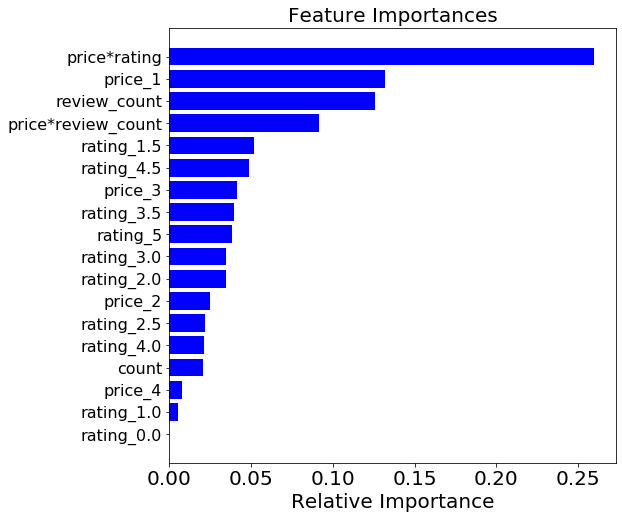

In [64]:
plt.figure(figsize=(8,8))
importances = best_rf.feature_importances_
indices = np.argsort(importances)
plt.title('Feature Importances',size=20)
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices], fontsize=16)
plt.xlabel('Relative Importance',size=20)
plt.xticks(size = 20)
plt.show()

# Using KMean Cluster to group Zipcodes

In [65]:
def transfer_tune(X, y, k):
    location_data = df_dummy[["latitude", "longitude"]]
    km = KMeans(n_clusters=k,random_state = 42 )
    km.fit(location_data)
    X.loc[:, "cluster"] = km.predict(location_data)
    X_dummy = pd.get_dummies(columns=["cluster"], data=X)
    X_train, X_test, y_train, y_test = train_test_split(
        X_dummy.copy(), y.copy(), random_state=42, test_size=0.3
    )
    best_rf.fit(X_train, y_train)
    r2 =best_rf.score(X_test, y_test)
    print(f"{k} : {r2}")

In [66]:
for k in range(20, 60, 1):
    transfer_tune(X, y, k)

20 : 0.538630030987908
21 : 0.6009522064167396
22 : 0.5647448503220827
23 : 0.564861655462773
24 : 0.5708179792571086
25 : 0.5350897158135877
26 : 0.5533220209386069
27 : 0.5577990572369843
28 : 0.5480476116548403
29 : 0.5571372532895876
30 : 0.5731776046173944
31 : 0.5391766670120098
32 : 0.5532797777107825
33 : 0.5576840218550252
34 : 0.5764200894678692
35 : 0.5612867373136625
36 : 0.5500181516848786
37 : 0.5691327600452878
38 : 0.5494358953959488
39 : 0.5647487477344435
40 : 0.566241784080004
41 : 0.5642000861098458
42 : 0.5738582544938433
43 : 0.5579237326612543
44 : 0.5526366879212583
45 : 0.5654314901042233
46 : 0.5565925617604583
47 : 0.5622344886286719
48 : 0.5506796129165613
49 : 0.547124259739044
50 : 0.5475820830962059
51 : 0.5673972689907189
52 : 0.5724593616679887
53 : 0.5361471247802215
54 : 0.5451433006919417
55 : 0.5632626936967573
56 : 0.5370541996096267
57 : 0.5625922038464368
58 : 0.5594388295044278
59 : 0.5551240882761672


In [67]:
location_data = df_dummy[["latitude", "longitude"]]
km = KMeans(n_clusters=21, random_state = 42)
km.fit(location_data)
X.loc[:, "cluster"] = km.predict(location_data)
X_dummy = pd.get_dummies(columns=["cluster"], data=X)
X_train, X_test, y_train, y_test = train_test_split(
        X_dummy.copy(), y.copy(), random_state=42, test_size=0.3
)

best_rf.fit(X_train, y_train)
r2 = best_rf.score(X_test, y_test)
print (r2)

0.5868970739663226


In [68]:
# Columns used in this order, need to copy and paste to app.py
# Because Pandas rearranges order in alphabetical order when save to csv

X_train.columns

Index(['count', 'review_count', 'price*rating', 'price*review_count',
       'price_1', 'price_2', 'price_3', 'price_4', 'rating_0.0', 'rating_1.0',
       'rating_1.5', 'rating_2.0', 'rating_2.5', 'rating_3.0', 'rating_3.5',
       'rating_4.0', 'rating_4.5', 'rating_5', 'cluster_0', 'cluster_1',
       'cluster_2', 'cluster_3', 'cluster_4', 'cluster_5', 'cluster_6',
       'cluster_7', 'cluster_8', 'cluster_9', 'cluster_10', 'cluster_11',
       'cluster_12', 'cluster_13', 'cluster_14', 'cluster_15', 'cluster_16',
       'cluster_17', 'cluster_18', 'cluster_19', 'cluster_20'],
      dtype='object')

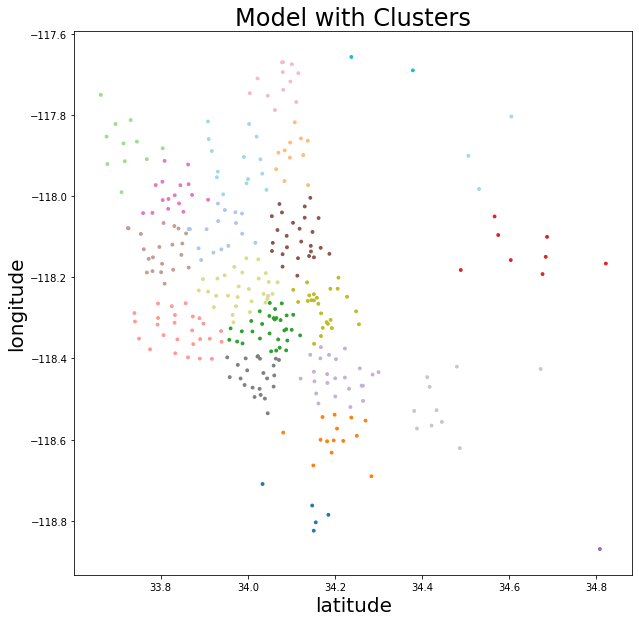

In [69]:
plt.figure(figsize=(10, 10))
plt.scatter(df_dummy.latitude, df_dummy.longitude, c=km.labels_, s=8, cmap="tab20")
plt.xlabel("latitude", fontsize = 20)
plt.ylabel("longitude", fontsize = 20)
plt.title('Model with Clusters', fontsize = 24);

In [70]:
# creating .csv file to make predictions from in Flask app

X_cluster = pd.concat([X_train,X_test],axis = 0, sort = False)
X_cluster = pd.concat([df_dummy['zip_code'],X_cluster.sort_index()],axis = 1)

X_cluster.to_csv('../data/X_cluster.csv')

In [71]:
y_pred = best_bag.predict(X_test)

In [72]:
residuals = np.exp(y_test )- np.exp(y_pred)

In [73]:
residuals.mean()

8538.377602066148

Text(0.5, 1.0, 'Residual Mean')

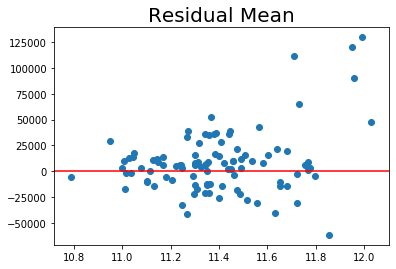

In [74]:
plt.scatter(y_pred, residuals)
plt.axhline(0, color='r')
plt.title('Residual Mean',size = 20)
#plt.savefig('./plots/residual.png')

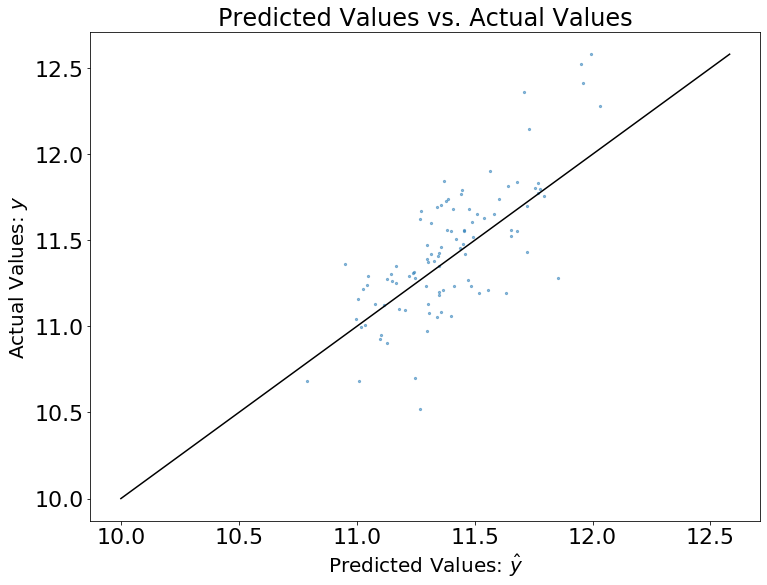

In [75]:

plt.figure(figsize=(12,9))
plt.rc('font', size=22)
# Generate a scatterplot of predicted values versus actual values.
plt.scatter(y_pred, y_test, s=5, alpha = 0.5)

# Plot a line.
plt.plot([10, np.max(y_test)],
         [10, np.max(y_test)],
         color = 'black')

# Tweak title and axis labels.
plt.xlabel("Predicted Values: $\hat{y}$", fontsize = 20)
plt.ylabel("Actual Values: $y$", fontsize = 20)
plt.title('Predicted Values vs. Actual Values', fontsize = 24);

In [76]:
# Pickle to be used in Flask app
pickle.dump(best_bag, open('../flask_app_complete/model.p', 'wb'))